In [1]:
%load_ext autoreload
%autoreload 2

import logging
import numpy as np
from munch import Munch
from scipy.stats import ortho_group
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Normal, Independent
from torch.utils.data import DataLoader
from pyro.nn import DenseNN
from pyro.distributions.transforms import AffineCoupling

from vaemcmc.models.encoders import EncoderMLP
from vaemcmc.models.decoders import DecoderMLP
from vaemcmc.vae import NormalNormalVAE, VAETarget, VAEProposal
from vaemcmc.mcmc import ISIRKernel
from vaemcmc.datasets.synthetic import SyntheticDataset
from vaemcmc.trainer import Trainer
from vaemcmc.viz.synthetic import plot_kde, plot_chain, scatter
from vaemcmc.models.rnvp import RNVP, FlowML

from vaemcmc.distributions.synthetic import Funnel
from vaemcmc.distributions.transforms import GaussianEmbedding

/Users/evgeny/miniconda3/envs/vaemcmc/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
args = Munch(
    amb_dim = 256,
    manifold_dim = 8,
    lat_dim = 16,
    hidden_dim = 128,
    n_blocks = 3,
    n_particles = 25,
    n_chains = 10,
    burn_in = 500,
    n_samples = 1000,
    n_epoch = 35,
    dummy_noise_scale = 0.5,
)


In [4]:
xlim = (-15, 15)
ylim = (-4, 4)

PROJ = (args.manifold_dim - 2, args.manifold_dim - 1)

manifold_target = Funnel(dim=args.manifold_dim, a=1)
# transform = torch.randn(AMB_DIM, AMB_DIM) + 3 * torch.eye(AMB_DIM)
transform = torch.FloatTensor(ortho_group.rvs(dim=args.amb_dim))
target = GaussianEmbedding(manifold_target, args.amb_dim, transform, args.dummy_noise_scale, device)

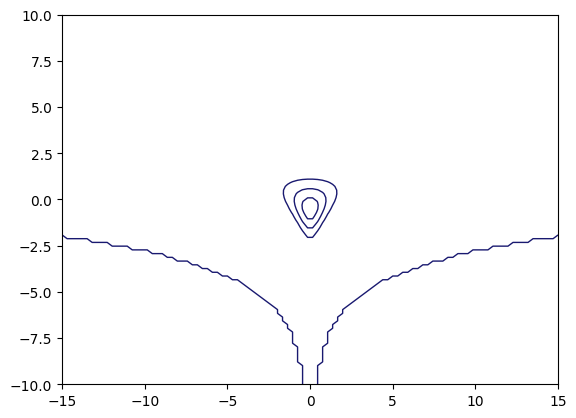

In [5]:
ax = plt.subplot()
target.plot_2d_contour(ax)
# ax.axis('auto')

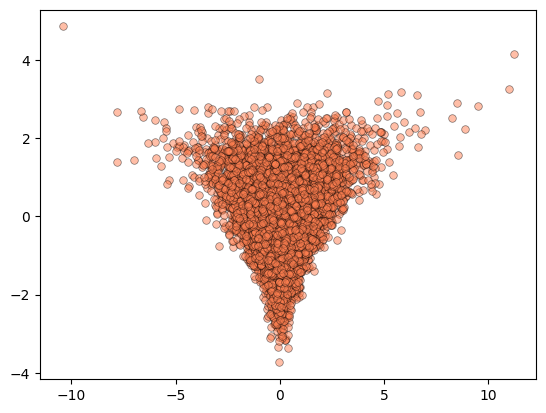

In [6]:
true_sample = target.sample((args.n_chains * args.n_samples,))
true_sample_proj = target.inv_embed(true_sample)
scatter(true_sample_proj[..., PROJ]);

In [7]:

# train_dataset = TensorDataset(target.sample(1000))
train_dataset = SyntheticDataset(target.sample((10000,)))
train_dataloader = DataLoader(train_dataset, batch_size=16)

val_dataset = SyntheticDataset(target.sample((10000,)))
val_dataloader = DataLoader(val_dataset, batch_size=16)

encoder = EncoderMLP(args.amb_dim, 2 * args.lat_dim, args.hidden_dim, n_layers=args.n_blocks)
decoder = DecoderMLP(args.lat_dim, 2 * args.amb_dim, args.hidden_dim, n_layers=args.n_blocks)

vae = NormalNormalVAE(encoder, decoder, fix_sigma=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

logging.basicConfig(format='%(asctime)s [%(levelname)-8s] %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)
    
trainer = Trainer(vae, optimizer, train_dataloader, val_dataloader=val_dataloader, logger=logger)


In [8]:
trainer.train(args.n_epoch)

2023-06-01 14:08:15,445 [INFO    ] 3%|2         | 1/35 [00:02<01:22,  2.42s/it]
2023-06-01 14:08:16,870 [INFO    ] Loss: 220.69906616210938
2023-06-01 14:08:20,106 [INFO    ] 9%|8         | 3/35 [00:07<01:15,  2.36s/it]
2023-06-01 14:08:20,510 [INFO    ] Loss: 199.19190979003906
2023-06-01 14:08:22,158 [INFO    ] 11%|#1        | 4/35 [00:09<01:09,  2.24s/it]
2023-06-01 14:08:24,089 [INFO    ] Loss: 197.3418426513672
2023-06-01 14:08:27,304 [INFO    ] 17%|#7        | 6/35 [00:14<01:11,  2.45s/it]
2023-06-01 14:08:28,275 [INFO    ] Loss: 201.15362548828125
2023-06-01 14:08:30,014 [INFO    ] 20%|##        | 7/35 [00:16<01:10,  2.53s/it]
2023-06-01 14:08:32,335 [INFO    ] Loss: 199.2079315185547
2023-06-01 14:08:34,544 [INFO    ] 26%|##5       | 9/35 [00:21<01:02,  2.39s/it]
2023-06-01 14:08:36,284 [INFO    ] Loss: 211.39883422851562
2023-06-01 14:08:40,539 [INFO    ] 31%|###1      | 11/35 [00:27<01:04,  2.70s/it]
2023-06-01 14:08:41,118 [INFO    ] Loss: 192.421875
2023-06-01 14:08:43,212 

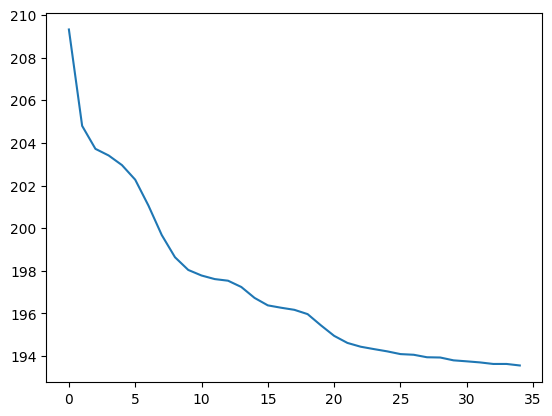

In [9]:
plt.plot(trainer.training_stats['epoch_loss'])

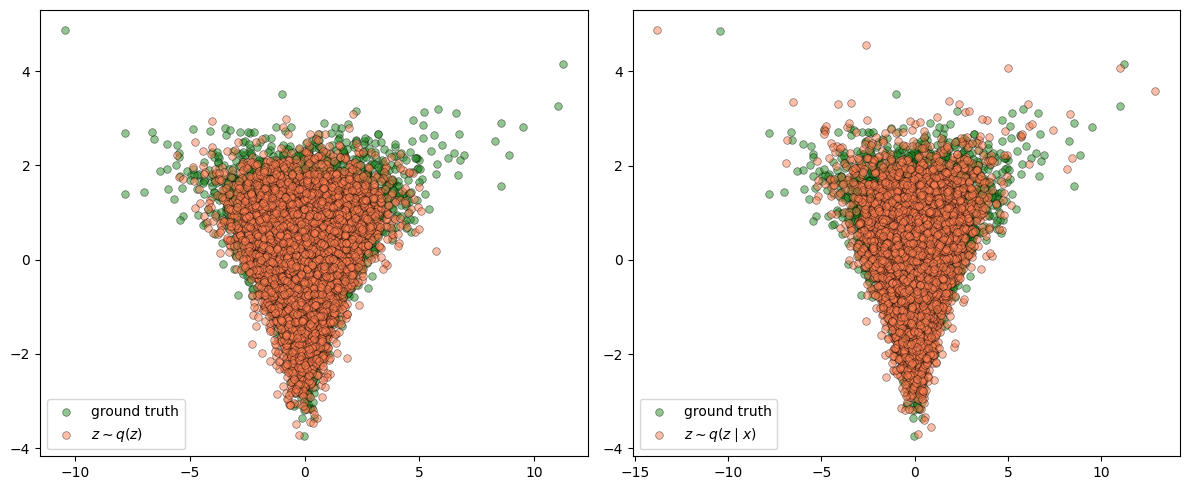

In [10]:
vae_sample = vae.sample((args.n_chains * args.n_samples,)).detach().cpu()
rec = vae(true_sample)[0].detach().cpu()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs = axs.flatten()
for ax in axs:
    scatter(target.inv_embed(true_sample)[..., PROJ], c='forestgreen', ax=ax, label='ground truth')
    
scatter(target.inv_embed(vae_sample)[..., PROJ].view(-1, 2), ax=axs[0], label=r'$z \sim q(z)$')
scatter(target.inv_embed(rec)[..., PROJ].view(-1, 2), ax=axs[1], label=r'$z \sim q(z \mid x)$')

fig.tight_layout()
for ax in axs:
    ax.legend()


In [11]:
# proposal = Independent(Normal(torch.zeros(args.lat_dim), 2 * torch.ones(args.lat_dim)), 1)

# z_start = proposal.sample((args.n_chains,))

# target_vae = VAETarget(vae, target)
# isir_kernel = ISIRKernel(target_vae, proposal=proposal, n_particles=args.n_particles)

# vae_z_chain = isir_kernel.run(z_start, args.burn_in, args.n_samples)
# vae_x_chain = vae.cond_sample(vae_z_chain).detach().cpu()

In [12]:
prior = Independent(Normal(torch.zeros(args.lat_dim), 0.5 ** .5 * torch.ones(args.lat_dim)), 1)
proposal = VAEProposal(vae, prior)

x_start = true_sample[np.random.choice(np.arange(true_sample.shape[0]), args.n_chains)]
x_start = proposal.sample((args.n_chains,))

isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=args.n_particles)
vae_x_chain = isir_kernel.run(x_start, args.burn_in, args.n_samples)

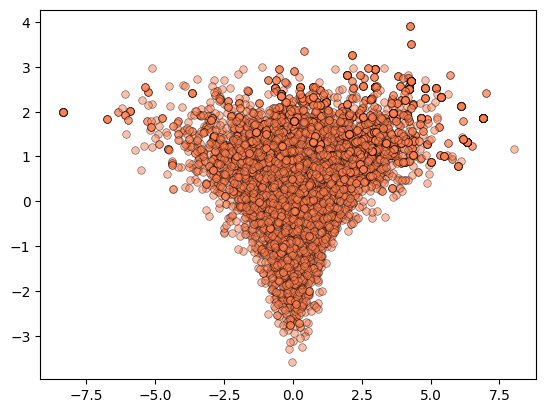

In [13]:
scatter(target.inv_embed(vae_x_chain)[..., PROJ].view(-1, 2));

(-4.0, 4.0)

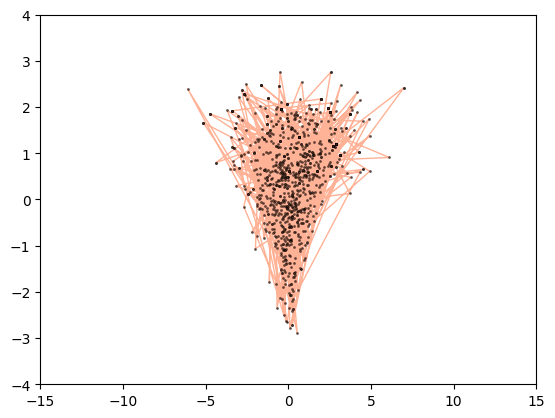

In [14]:
fig = plot_chain(target.inv_embed(vae_x_chain)[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


In [15]:
split_dim = max(args.amb_dim - args.hidden_dim, args.amb_dim // 2)
flows = [
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [args.hidden_dim],
            [args.amb_dim - split_dim, args.amb_dim - split_dim],
        ),
    )
    for _ in range(args.n_blocks - 1)
]
split_dim = max(args.amb_dim - args.hidden_dim, args.amb_dim // 2)
flows.append(
    AffineCoupling(
        split_dim,
        DenseNN(
            split_dim,
            [args.hidden_dim],
            [args.amb_dim - split_dim, args.amb_dim - split_dim],
        ),
    )
)

rnvp = RNVP(flows=flows, dim=args.amb_dim)
rnvp_ml = FlowML(rnvp)
optimizer = torch.optim.Adam(rnvp_ml.parameters(), lr=3e-4)
trainer = Trainer(rnvp_ml, optimizer, train_dataloader, val_dataloader)

In [16]:
trainer.train(args.n_epoch)

2023-06-01 14:09:55,323 [INFO    ] 3%|2         | 1/35 [00:02<01:26,  2.55s/it]
2023-06-01 14:09:56,805 [INFO    ] Loss: 214.2831573486328
2023-06-01 14:10:00,367 [INFO    ] 9%|8         | 3/35 [00:07<01:21,  2.54s/it]
2023-06-01 14:10:00,892 [INFO    ] Loss: 192.5443115234375
2023-06-01 14:10:03,249 [INFO    ] 11%|#1        | 4/35 [00:10<01:22,  2.67s/it]
2023-06-01 14:10:05,223 [INFO    ] Loss: 193.9923095703125
2023-06-01 14:10:08,672 [INFO    ] 17%|#7        | 6/35 [00:15<01:18,  2.70s/it]
2023-06-01 14:10:09,804 [INFO    ] Loss: 197.1414337158203
2023-06-01 14:10:11,627 [INFO    ] 20%|##        | 7/35 [00:18<01:17,  2.78s/it]
2023-06-01 14:10:14,632 [INFO    ] Loss: 196.3009796142578
2023-06-01 14:10:17,173 [INFO    ] 26%|##5       | 9/35 [00:24<01:11,  2.76s/it]
2023-06-01 14:10:18,871 [INFO    ] Loss: 204.468994140625
2023-06-01 14:10:22,633 [INFO    ] 31%|###1      | 11/35 [00:29<01:05,  2.73s/it]
2023-06-01 14:10:23,148 [INFO    ] Loss: 190.38824462890625
2023-06-01 14:10:25,1

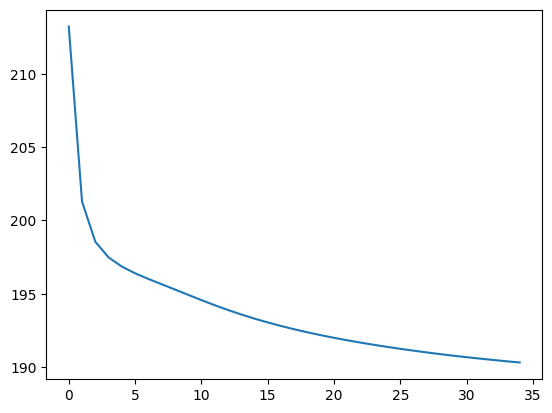

In [17]:
plt.plot(trainer.training_stats['epoch_loss'])

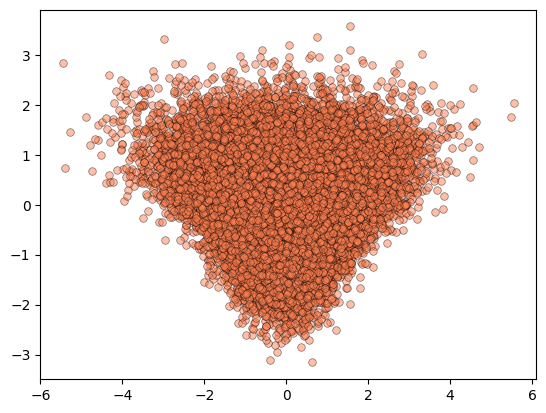

In [18]:
rnvp_sample = rnvp.sample((500 * 100,)).detach().cpu()

scatter(target.inv_embed(rnvp_sample)[:, PROJ]);

In [19]:
rnvp.prior = Independent(Normal(torch.zeros(args.amb_dim), 1 ** .5 * torch.ones(args.amb_dim)), 1)
proposal = rnvp

isir_kernel = ISIRKernel(target, proposal=proposal, n_particles=args.n_particles)

In [20]:
z_start = rnvp.sample((args.n_chains,))
rnvp_x_chain = isir_kernel.run(z_start, args.burn_in, args.n_samples)

In [21]:
# x_start = flow.inverse(z_start)[0].detach().cpu()
# x_chain = flow.inverse(chain)[0].detach().cpu()
x_start = z_start.detach().cpu()
rnvp_x_chain = rnvp_x_chain.detach().cpu()

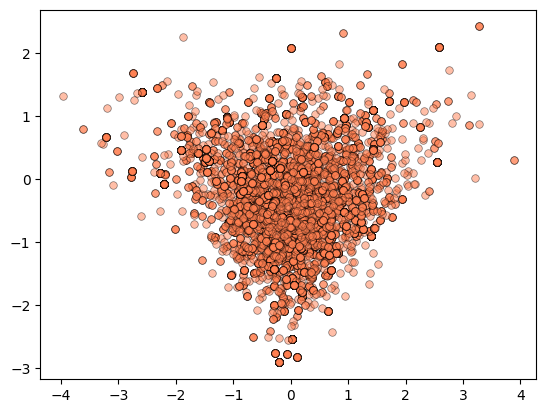

In [22]:
scatter(target.inv_embed(rnvp_x_chain)[..., PROJ].view(-1, 2));


In [23]:
# fig = plot_kde(rnvp_x_chain[..., PROJ], xlim, ylim)
# ax = fig.get_axes()[0]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# # ax.set_aspect('equal')


(-4.0, 4.0)

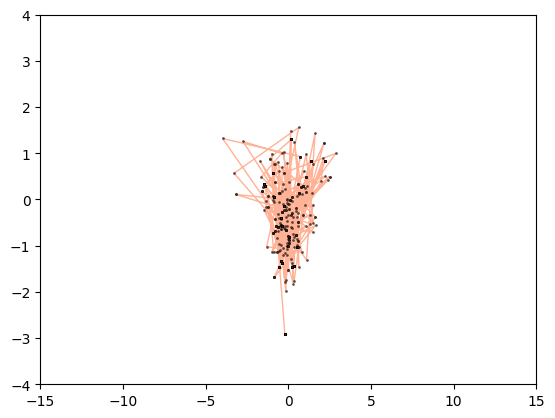

In [24]:
fig = plot_chain(target.inv_embed(rnvp_x_chain)[:, 0, PROJ])
ax = fig.get_axes()[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_aspect('equal')


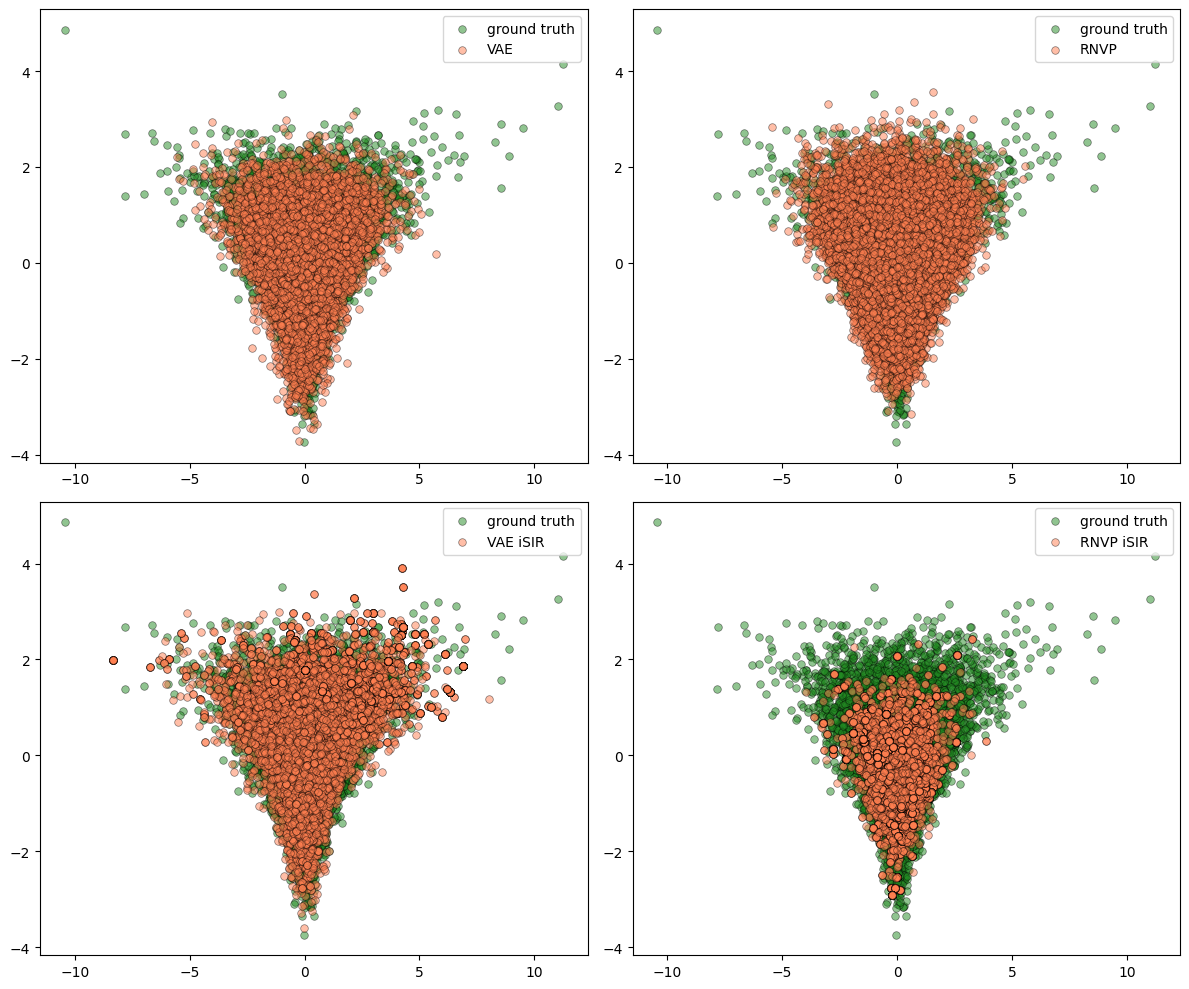

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs = axs.flatten()
for ax in axs:
    scatter(target.inv_embed(true_sample)[..., PROJ], c='forestgreen', ax=ax, label='ground truth')
    
scatter(target.inv_embed(vae_sample)[..., PROJ].view(-1, 2), ax=axs[0], label='VAE')
scatter(target.inv_embed(rnvp_sample)[..., PROJ].view(-1, 2), ax=axs[1], label='RNVP')

scatter(target.inv_embed(vae_x_chain)[..., PROJ].view(-1, 2), ax=axs[2], label='VAE iSIR')
scatter(target.inv_embed(rnvp_x_chain)[..., PROJ].view(-1, 2), ax=axs[3], label='RNVP iSIR')

fig.tight_layout()
for ax in axs:
    ax.legend()
plt.savefig('../figs/vae_rnvp_funnel_embed.png')